## Introducing Fire Reanalysis using Earthkit

**earthkit** is an **open-source** Python project led by ECMWF, providing powerful tools for speeding up weather and climate science workflows by simplifying **data access**, **processing**, **analysis**, **visualisation** and more.

**earthkit** lowers the barrier to entry for interacting with climate data in Python by providing high-level, easy-to-use functions for performing common data analysis and visualisation tasks. Designed to be **format-agnostic**, **earthkit** allows you to focus on working with whatever data you have without worrying about technical issues like data formats.

**earthkit** is currently in the *alpha* stage of development, but is already available in GitHub, PyPI and conda as an open-source project than can be installed, played with and contributed to. **earthkit** will become the recommended library for retrieving, analysing and visualising CDS and ADS data when it releases in 2024, replacing the legacy *CDS Toolbox*.

These notebooks provide an introduction to using earthkit as a one-stop-shop for speeding up your workflows for interacting with CDS data.

To get started, import the `earthkit` module.

In [1]:
import earthkit as ek
import earthkit.maps
import os
os.remove

<function posix.remove(path, *, dir_fd=None)>

### Retrieving data from the CDS

The core function we will be using for retrieving and opening data is `ek.data.from_source`. You can use this function to open data from many different sources, such as URLs, local files, and of course the CDS.

To access data from the CDS source, we need to pass `"cds"` as the first argument to `ek.data.from_source`. The other arguments are exactly the same arguments expected by the CDS API - that is, the name of the dataset followed by the request payload. If you're familiar with the **CDS API**, you'll already be acquainted with the syntax for these requests.

In the following example, we will retrieve data from the CDS dataset [ERA5 monthly averaged data on single levels from 1940 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form). We will access monthly-averaged 2m temperature for the month of September 2022:

In [ ]:
# This is the new method of downloading but it does not yet support the EWDS, keeping it here for when its ready...
LOCAL_DATA_DIR = "data/"
TARGET=f"{LOCAL_DATA_DIR}/fwinx_seasonal.grib"
os.makedirs(LOCAL_DATA_DIR,exist_ok=True)
steps = [str(step) for step in range(12,5160,24)]
if not os.path.exists(TARGET):
    fwi_data = ek.data.from_source(
        "cds",
        "cems-fire-seasonal",
        {
            "variable": ["fire_weather_index"],
            "release_version": "5",
            "year": ["2024"],
            "month": ["09"],
            "day": ["01"],
            "leadtime_hour": steps,
            "data_format": "grib"
        },
        target=TARGET
    )
else:
    fwi_data = ek.data.from_source("file", TARGET)

One advantage of **earthkit** over the legacy CDS API is that local downloads and caching are automatically handled for you. That means that you don't need to save your request to a specific file and then read that file into Python - it's all handled in one step. By default, files will be removed from your local cache after a few days - so you don't even need to worry about cleaning up files you no longer need, as they will be automatically housekept!

Note that we didn't include a `format` key in our request payload, even though ERA5 can be retrieved in either GRIB or netCDF format. **earthkit** is designed to be **format agnostic** - that is, earthkit tools should work in exactly the same way whether you have GRIB data *or* netCDF data, so we can comfortably exclude the data format from our request and accept the default selection made by the CDS.

The `data` object that has been returned from our CDS request is a special kind of **earthkit** object, providing a range of convenient methods for interrogating a data source or converting it to a format that's familiar to you, such as xarray, numpy or pandas - or saving to a local file.

In [3]:
fwi_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,fwinx,surface,0,20240901,0,None,fc,0,regular_ll
1,ecmf,fwinx,surface,0,20240901,0,None,fc,1,regular_ll
2,ecmf,fwinx,surface,0,20240901,0,None,fc,2,regular_ll
3,ecmf,fwinx,surface,0,20240901,0,None,fc,3,regular_ll
4,ecmf,fwinx,surface,0,20240901,0,None,fc,4,regular_ll
...,...,...,...,...,...,...,...,...,...,...
10960,ecmf,fwinx,surface,0,20240901,0,None,fc,46,regular_ll
10961,ecmf,fwinx,surface,0,20240901,0,None,fc,47,regular_ll
10962,ecmf,fwinx,surface,0,20240901,0,None,fc,48,regular_ll
10963,ecmf,fwinx,surface,0,20240901,0,None,fc,49,regular_ll


In [4]:
# Convert to an xarray Dataset object
xfwi_data = fwi_data.to_xarray()
xfwi_data = xfwi_data.assign_coords(longitude=(((xfwi_data.longitude + 180) % 360) - 180)).sortby('longitude')
print(xfwi_data)    

<xarray.Dataset> Size: 6GB
Dimensions:    (number: 51, step: 215, latitude: 181, longitude: 360)
Coordinates:
  * number     (number) int64 408B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * step       (step) timedelta64[ns] 2kB 0 days 12:00:00 ... 214 days 12:00:00
  * latitude   (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
Data variables:
    fwinx      (number, step, latitude, longitude) float64 6GB ...
Attributes: (12/13)
    param:        fwinx
    class:        gw
    stream:       mmsf
    levtype:      sfc
    type:         fc
    expver:       0001
    ...           ...
    time:         0
    origin:       ecmf_od
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF


In [5]:
import pandas as pd
import xarray as xr
from datetime import datetime,timedelta
start_date=datetime.strptime(str(xfwi_data.date)+'12',"%Y%m%d%H")
end_date=start_date+timedelta(days=len(steps)-1)
# times = pd.date_range(start_date.strftime("%Y/%m/%d %H"),end_date.strftime("%Y/%m/%d %H"),freq='D')
times = pd.date_range(start_date.strftime("%Y/%m/%d"),start_date.strftime("%Y/%m/%d"),freq='D')
time_da = xr.DataArray(times, [('time', times)])
xfwi_data2=xfwi_data.expand_dims(time=time_da)
# xfwi_data2 = xfwi_data2.drop_dims("step")
# del xfwi_data
xfwi_data2.coords["valid_time"] = (
    xfwi_data2["time"] + xfwi_data2["step"]
)
xfwi_data2

<xarray.Dataset> Size: 6GB
Dimensions:     (time: 1, number: 51, step: 215, latitude: 181, longitude: 360)
Coordinates:
  * time        (time) datetime64[ns] 8B 2024-09-01
  * number      (number) int64 408B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * step        (step) timedelta64[ns] 2kB 0 days 12:00:00 ... 214 days 12:00:00
  * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
    valid_time  (time, step) datetime64[ns] 2kB 2024-09-01T12:00:00 ... 2025-...
Data variables:
    fwinx       (time, number, step, latitude, longitude) float64 6GB nan ......
Attributes: (12/13)
    param:        fwinx
    class:        gw
    stream:       mmsf
    levtype:      sfc
    type:         fc
    expver:       0001
    ...           ...
    time:         0
    origin:       ecmf_od
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF

In [6]:
fwi_monthly_average_per_mem = ek.transforms.aggregate.temporal.monthly_mean(xfwi_data2,time_dim="valid_time")
fwi_monthly_average_per_mem

<xarray.Dataset> Size: 213MB
Dimensions:    (year_months: 8, number: 51, latitude: 181, longitude: 360)
Coordinates:
  * number     (number) int64 408B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * latitude   (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
Dimensions without coordinates: year_months
Data variables:
    fwinx      (year_months, number, latitude, longitude) float64 213MB nan ....
Attributes: (12/13)
    param:        fwinx
    class:        gw
    stream:       mmsf
    levtype:      sfc
    type:         fc
    expver:       0001
    ...           ...
    time:         0
    origin:       ecmf_od
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF

   
# Instantiate a Superplot object with the domain set to "Europe"
# earthkit-maps allows named domains based on many presets, including
# continents, countries and more - so feel free to experiment with domains!
for m in range(fwi_monthly_average_per_mem.year_months.shape[0]):
    chart = ek.maps.Chart(domain="Europe")

    gust_style = earthkit.maps.Style(
        colors=["#486d19","#30a053","#aedd78","#e4f4ac","#ffff84","#fdce8c","#f1895b","#e65b47","#db2f32","#bf5922","#723f31"],
        levels=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 100]  ,
    )
    # chart.plot will attempt to find a suitable style for the data based
    # on its metadata - usually the name of the variable we're plotting.
    # We can also specifically tailor the style to use some units of choice,
    # in this case celsius - but this depends on a corresponding pre-configured
    #style existing within earthkit-maps.
    # In the next notebook we will explore how to create custom styles.
    chart.plot(fwi_monthly_average_per_mem.fwinx[m,0,:,:], units="celsius", style=gust_style)

    # The API for adding auxilliary layers is very straightforward
    chart.coastlines()
    chart.borders()
    chart.gridlines()

    # Titles can include template keys between curely brackets, which are
    # extracted from the data's metadata. This makes it much easier to transfer
    # code between projects, without having to completely re-write titles
    chart.title("{variable_name} in {domain}")
    chart.legend(location="right")

    chart.show()

### Quick visualisation with **earthkit-maps**

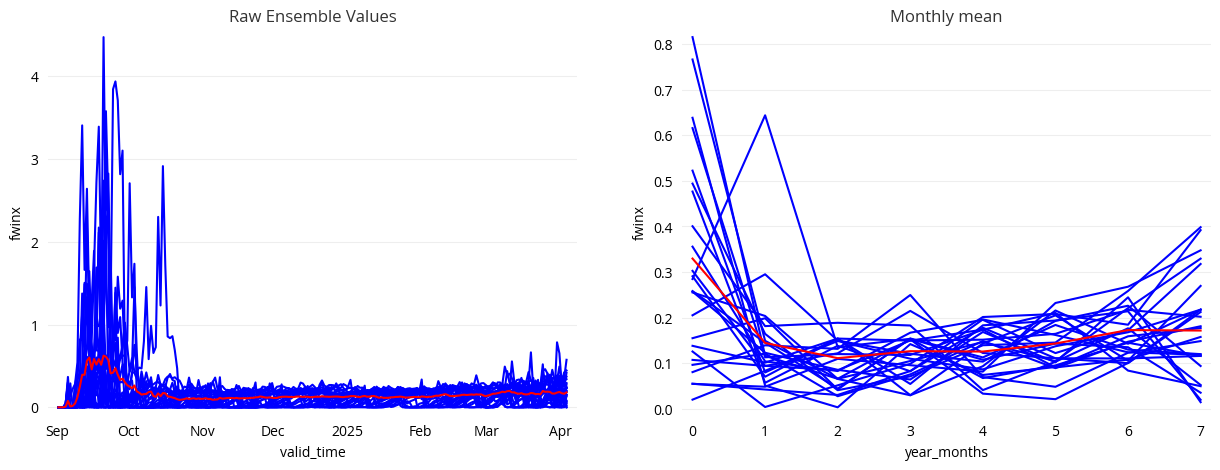

In [7]:
import matplotlib.pyplot as plt
isel_kwargs = {"latitude":30, "longitude":-40}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
forecast_colours = ["blue", "red", "green"]

# Plot 1
mean_data=xfwi_data2.fwinx.isel(**isel_kwargs).mean("number")
for number in range(25):
    data = xfwi_data2.fwinx.isel(**isel_kwargs, number=number)
    extra_kwargs = {}

    data.plot(
        x = "valid_time",
        ax=axes[0], color=forecast_colours[0], **extra_kwargs
        
        )
mean_data.plot(x = "valid_time", ax=axes[0], color=forecast_colours[1], **extra_kwargs)
f_kwargs = {"label": "Daily median over step"}
axes[0].set_title("Raw Ensemble Values")

# Plot 2
mean_data=fwi_monthly_average_per_mem.fwinx.isel(**isel_kwargs).mean("number")
for number in range(25):
    data = fwi_monthly_average_per_mem.fwinx.isel(**isel_kwargs, number=number)
    extra_kwargs = {}
    data.plot(
        x = "year_months",
        ax=axes[1], color=forecast_colours[0], **extra_kwargs
        )

mean_data.plot(x = "year_months", ax=axes[1], color=forecast_colours[1], **extra_kwargs)
axes[1].set_title("Monthly mean")

plt.show()